# Computing shap values for BigML models 
The Shap library can be used to compute shap (SHapley Additive exPlanations) values. Those are being used to understand the influence of each feature in your dataset on your ML prediction. The minimal requiremet for that to work is that the model provides a predict function that accepts inputs as numpy arrays and . BigML's models are white-box and the Python bindings provide classes that can handle their information to provide such predictions. Therefore, the only thing we need to ensure is that the interfaces of Shap and BigML functions match, and that's the goal of the ShapWrapper class in the Python bindings. Let's see some examples of that. We'll start by using a simple regression model and evolve to one with both numeric and categorical variables to see how to create shap visualizations for all of them

## Installation
The first step will be installing the BigML Python bindings and the Shap library in your environment. Then importing the Shap library and loading the Javascript visualization code to the notebook. We will also install the Pandas library, that is the popular tool to handle data transformations.

In [ ]:
!pip install bigml
!pip install shap
!pip install pandas as pd

In [10]:
import shap
shap.initjs()


/home/merce/.virtualenv/python3.8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## First use case: Regression shap values
As our first example, we'll look for house pricing predictions. The historical data can be extracted from one of the scikit learn datasets: California House Pricing. It contains data about the medium price of Houses in California and their features, like their age, the number of bedrooms or bathrooms, etc.

In [2]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing(as_frame=True)
california_housing.data = california_housing.data.assign(MedHouseVal=california_housing.target)
df = pd.DataFrame(california_housing.data)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Splitting for training and testing
As usual, we'll create a train/test split to ensure that we can evaluate our model. Using an 80/20 split, we'll create most of the data to generate a regression model.

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

### Training the model
And now we'll upload the training data to BigML and we'll create a Decision Tree model from it to predict the last field, which is the `MedHouseVal` field.

In [31]:
from bigml.api import BigML
USERNAME = "my_username" # change to use your own credentials
API_KEY = "my_api_key" # change to use your own credentials (https://bigml.com/account/apikey)
api = BigML(USERNAME, API_KEY)
source = api.create_source(train)
dataset = api.create_dataset(source)
model = api.create_model(dataset)

The model creation has been started, but we need to wait for the training to be complete using the `.ok` method.

In [32]:
api.ok(model)

True

### Evaluating the model
And as a requirement, we should try the performance of our model by testing with a complementary test dataset. The data is uploaded and summarized in a dataset to be used in the evaluation and we wait to be finished to check the evaluation metrics.

In [33]:
test_source = api.create_source(test)
test_dataset = api.create_dataset(test_source)
evaluation = api.create_evaluation(model, test_dataset)
api.ok(evaluation)

In this case, we check the `r-squared` metric as an indication of the model's performance. This is one of the attributes defined in the `Evaluation` class. 

In [34]:
from bigml.evaluation import Evaluation
local_evaluation = Evaluation(evaluation)
print(f"R-squared: {local_evaluation.r_squared}")

R-squared: 0.63542


### Creating Explanations
The model's `r-squared` is not optimal, but it's high enough so that the model can be doing sensible predictions. Therefore, we'll start analyzing the input features that contribute to these predictions and whether the contributions are positive or negative using the Shap library. In order to do that, we build an object that will expose the `.predict` and `.predict_prob` methods used in the `Explainer` constructor.

In [51]:
from bigml.shapwrapper import ShapWrapper
shap_wrapper = ShapWrapper(model)

The Explainer expects all data to be provided as numeric numpy arrays. Our dataset contains only numeric fields, so in this case transformations should be trivial. However, we'll see later other cases where categorical fields need to be one-hot encoded in order to be fed to the `Explainer` constructor. BigML's `Fields` class stores the field types information and provides `.from_numpy` and `.to_numpy` functions ready to do the corresponding translation.

In [ ]:
from bigml.fields import Fields
fields = Fields(model)
X_test = fields.to_numpy(test.drop(columns=shap_wrapper.y_header))

Now, everything is ready to build the corresponding `Explainer` and obtain from it the shap values for the input features.

In [85]:
explainer = shap.Explainer(shap_wrapper.predict, X_test, algorithm='partition', feature_names=shap_wrapper.x_headers)
shap_values = explainer(X_test)

  0%|                                                    | 0/56 [00:00<?, ?it/s]
80it [00:00, 179.02it/s]                                                        
  0%|                                                    | 0/56 [00:00<?, ?it/s]
84it [00:00, 274.56it/s]                                                        
  0%|                                                    | 0/56 [00:00<?, ?it/s]
Partition explainer: 827it [52:02,  3.79s/it]                                   


And that enables us to analyze data using the `summary_plot`, which explains the global impact of the feature values on the target result.

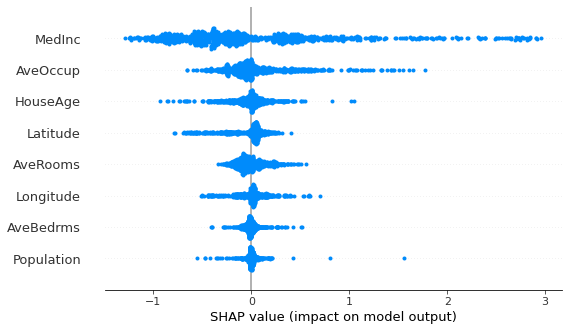

In [78]:
shap.summary_plot(shap_values)

Or the global importance of each input feature

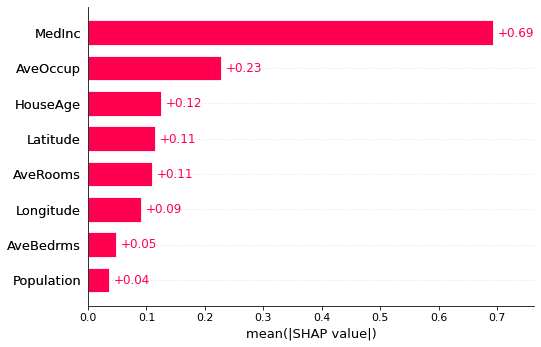

In [83]:
shap.plots.bar(shap_values)


And the features contribution to a particular prediction

Shap values. Predicting MedHouseVal from {'MedInc': 3.2663, 'HouseAge': 19.0, 'AveRooms': 3.6049129989764586, 'AveBedrms': 1.060388945752303, 'Population': 1820.0, 'AveOccup': 1.8628454452405323, 'Latitude': 34.04, 'Longitude': -118.46}


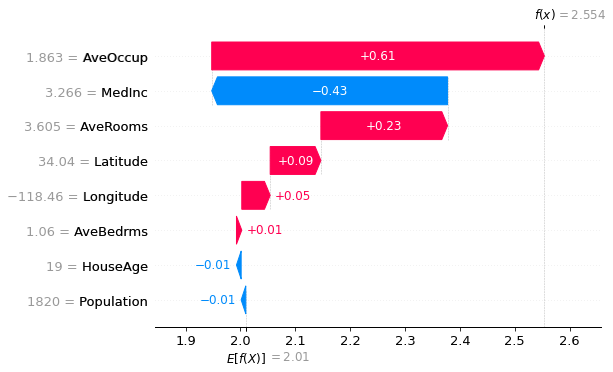

In [72]:
row_number = 2
example = dict(zip(shap_wrapper.x_headers, X_test[row_number])) 
print("Shap values. Predicting %s from %s" % (shap_wrapper.y_header, example))
shap.plots.waterfall(shap_values[row_number])

## Second use case: Classification shap values
In this example the objective field will be a categorical one. The data corresponds to the `Telecom Churn` dataset, which contains information about customers in a telecom company that churned or not. The rest of features describe the kind of products that they pay for (International plan, voice mail plan, etc.), their use of the service and the number of customer service calls.

In [2]:
import pandas as pd
#train = pd.read_csv("https://raw.githubusercontent.com/bensadeghi/pyspark-churn-prediction/master/data/churn-bigml-80.csv")
train = pd.read_csv("https://raw.githubusercontent.com/bensadeghi/pyspark-churn-prediction/master/data/churn-bigml-20.csv")
train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, test_size=0.2)

The steps to do that in BigML are identicial to the ones used in the previous section. Uploading data, creating a dataset and a model. 

In [4]:
from bigml.api import BigML
USERNAME = "mmartin" # change to use your own credentials
API_KEY = "866c7a8223469924c136bf8d232e5efbd9b60d00" # change to use your own credentials (https://bigml.com/account/apikey)
api = BigML(USERNAME, API_KEY)
source = api.create_source(train)
dataset = api.create_dataset(source)
model = api.create_model(dataset)
api.ok(model)

True

Again, we would certainly want to see the model's performance to ensure it has some predictive value. We create an evaluation to that end.

In [5]:
test_source = api.create_source(test)
test_dataset = api.create_dataset(test_source)
evaluation = api.create_evaluation(model, test_dataset)
api.ok(evaluation)

True

And use the local `Evaluation` object to get the main average metrics.

In [7]:
from bigml.evaluation import Evaluation
local_evaluation = Evaluation(evaluation)
print(f"Accuracy: {local_evaluation.accuracy}")
print(f"Precision: {local_evaluation.precision}")
print(f"Recall: {local_evaluation.recall}")

Accuracy: 0.93284
Precision: 0.85982
Recall: 0.79979


And the metrics for the `Churn="True"` case, which is interpreted to be the positive class.

In [8]:
print(f"Positive Class: {local_evaluation.positive_class.name}")
print(f"PC precision: {local_evaluation.positive_class.precision}")
print(f"PC recall: {local_evaluation.positive_class.recall}")

Positive Class: True
PC precision: 0.76923
PC recall: 0.625


If metrics are good enough, we can start using the model as a prediction function. For that, you can create the corresponding `ShapWrapper` object.

In [5]:
from bigml.shapwrapper import ShapWrapper
shap_wrapper = ShapWrapper(model)

And generate the `shap_values` using the corresponding `Explainer`. The differentce in this occasion is that some of the fields are categorical and need to be encoded. The `Fields` class offers methods to handle those too.

In [6]:
from bigml.fields import Fields
fields = Fields(model)
fields.list_fields()
print("Churn encoding: ", fields.one_hot_codes("Churn"))

[Account length                  : numeric         : 1       ]
[Area code                       : numeric         : 2       ]
[International plan              : categorical     : 3       ]
[Voice mail plan                 : categorical     : 4       ]
[Number vmail messages           : numeric         : 5       ]
[Total day minutes               : numeric         : 6       ]
[Total day calls                 : numeric         : 7       ]
[Total day charge                : numeric         : 8       ]
[Total eve minutes               : numeric         : 9       ]
[Total eve calls                 : numeric         : 10      ]
[Total eve charge                : numeric         : 11      ]
[Total night minutes             : numeric         : 12      ]
[Total night calls               : numeric         : 13      ]
[Total night charge              : numeric         : 14      ]
[Total intl minutes              : numeric         : 15      ]
[Total intl calls                : numeric         : 16

And those methods are used in the `.to_numpy` method to do the corresponding transformation automatically.

In [9]:
X_test = fields.to_numpy(test.drop(columns=shap_wrapper.y_header))
explainer = shap.Explainer(shap_wrapper.predict, X_test, algorithm='partition', feature_names=shap_wrapper.x_headers)
shap_values = explainer(X_test)


 98%|████████████████████████████████████████▏| 300/306 [00:12<00:00, 15.52it/s]
310it [00:13, 15.99it/s]                                                        
320it [00:13, 16.31it/s]
330it [00:14, 16.55it/s]
340it [00:14, 16.81it/s]
350it [00:15, 16.92it/s]
360it [00:16, 17.06it/s]
370it [00:16, 17.07it/s]
380it [00:17, 17.09it/s]
390it [00:17, 17.25it/s]
400it [00:18, 17.41it/s]
410it [00:19, 17.37it/s]
420it [00:19, 17.41it/s]
430it [00:20, 17.37it/s]
440it [00:20, 17.46it/s]
450it [00:21, 17.49it/s]
460it [00:21, 17.46it/s]
470it [00:22, 17.48it/s]
480it [00:23, 17.47it/s]
490it [00:23, 17.13it/s]
500it [00:24, 17.18it/s]
508it [00:24, 17.22it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.06it/s]
310it [00:12, 17.05it/s]                                                        
320it [00:12, 16.91it/s]
330it [00:13, 16.90it/s]
340it [00:14, 17.03it/s]
350it [00:14, 16.99it/s]
360it [00:15, 16.93it/s]
370it [00:15, 17.03it/s]
380it [00:16, 17.12it/s]
3

330it [00:13, 17.47it/s]
340it [00:13, 17.40it/s]
350it [00:14, 17.39it/s]
360it [00:15, 17.34it/s]
370it [00:15, 17.27it/s]
380it [00:16, 17.21it/s]
390it [00:16, 17.20it/s]
400it [00:17, 17.20it/s]
410it [00:18, 17.23it/s]
420it [00:18, 17.12it/s]
430it [00:19, 17.18it/s]
440it [00:19, 17.16it/s]
450it [00:20, 17.15it/s]
460it [00:20, 17.14it/s]
470it [00:21, 17.16it/s]
480it [00:22, 17.16it/s]
490it [00:22, 17.17it/s]
500it [00:23, 17.10it/s]
508it [00:23, 17.02it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:10<00:00, 17.52it/s]
310it [00:11, 17.51it/s]                                                        
320it [00:12, 17.42it/s]
330it [00:12, 17.78it/s]
340it [00:13, 17.88it/s]
350it [00:13, 17.79it/s]
360it [00:14, 17.22it/s]
370it [00:14, 17.35it/s]
380it [00:15, 17.47it/s]
390it [00:16, 17.44it/s]
400it [00:16, 17.46it/s]
410it [00:17, 17.41it/s]
420it [00:17, 17.46it/s]
430it [00:18, 17.42it/s]
440it [00:18, 17.33it/s]
450it [00:19, 17.34it/s]
460it [00:20,

310it [00:12, 16.95it/s]                                                        
320it [00:12, 17.02it/s]
330it [00:13, 17.37it/s]
340it [00:14, 17.72it/s]
350it [00:14, 17.69it/s]
360it [00:15, 17.70it/s]
370it [00:15, 17.78it/s]
380it [00:16, 17.54it/s]
390it [00:16, 17.25it/s]
400it [00:17, 17.15it/s]
410it [00:18, 17.16it/s]
420it [00:18, 17.19it/s]
430it [00:19, 17.16it/s]
440it [00:19, 17.03it/s]
450it [00:20, 17.03it/s]
460it [00:21, 16.83it/s]
470it [00:21, 16.93it/s]
480it [00:22, 16.97it/s]
490it [00:22, 16.89it/s]
500it [00:23, 17.03it/s]
508it [00:23, 17.05it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.59it/s]
310it [00:12, 17.80it/s]                                                        
320it [00:12, 17.55it/s]
330it [00:13, 17.77it/s]
340it [00:13, 17.49it/s]
350it [00:14, 17.33it/s]
360it [00:15, 17.23it/s]
370it [00:15, 17.15it/s]
380it [00:16, 17.09it/s]
390it [00:16, 16.96it/s]
400it [00:17, 16.96it/s]
410it [00:18, 16.92it/s]
420it [

 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.35it/s]
310it [00:12, 17.20it/s]                                                        
320it [00:12, 17.15it/s]
330it [00:13, 17.19it/s]
340it [00:13, 17.26it/s]
350it [00:14, 17.30it/s]
360it [00:15, 17.32it/s]
370it [00:15, 17.29it/s]
380it [00:16, 17.27it/s]
390it [00:16, 17.24it/s]
400it [00:17, 17.25it/s]
410it [00:18, 17.30it/s]
420it [00:18, 17.30it/s]
430it [00:19, 17.34it/s]
440it [00:19, 17.39it/s]
450it [00:20, 17.35it/s]
460it [00:20, 17.34it/s]
470it [00:21, 16.55it/s]
480it [00:22, 16.28it/s]
490it [00:22, 16.16it/s]
500it [00:23, 16.50it/s]
508it [00:23, 16.69it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 16.33it/s]
310it [00:12, 16.49it/s]                                                        
320it [00:12, 16.68it/s]
330it [00:13, 16.17it/s]
340it [00:14, 15.92it/s]
350it [00:14, 15.73it/s]
360it [00:15, 15.67it/s]
370it [00:16, 15.53it/s]
380it [00:16, 15.95it/s]
3

 98%|████████████████████████████████████████▏| 300/306 [00:10<00:00, 17.98it/s]
310it [00:11, 17.92it/s]                                                        
320it [00:11, 17.81it/s]
330it [00:12, 17.86it/s]
340it [00:12, 17.75it/s]
350it [00:13, 17.66it/s]
360it [00:14, 17.61it/s]
370it [00:14, 17.50it/s]
380it [00:15, 17.48it/s]
390it [00:15, 17.34it/s]
400it [00:16, 17.36it/s]
410it [00:17, 17.21it/s]
420it [00:17, 17.30it/s]
430it [00:18, 17.31it/s]
440it [00:18, 17.33it/s]
450it [00:19, 17.39it/s]
460it [00:19, 17.38it/s]
470it [00:20, 17.38it/s]
480it [00:21, 17.38it/s]
490it [00:21, 17.39it/s]
500it [00:22, 17.36it/s]
508it [00:22, 17.36it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.55it/s]
310it [00:12, 17.01it/s]                                                        
320it [00:12, 16.74it/s]
330it [00:13, 16.84it/s]
340it [00:13, 16.95it/s]
350it [00:14, 16.47it/s]
360it [00:15, 16.77it/s]
370it [00:15, 16.93it/s]
380it [00:16, 17.11it/s]
3

 98%|████████████████████████████████████████▏| 300/306 [00:10<00:00, 17.51it/s]
310it [00:11, 17.54it/s]                                                        
320it [00:12, 17.55it/s]
330it [00:12, 17.48it/s]
340it [00:13, 17.47it/s]
350it [00:13, 17.50it/s]
360it [00:14, 17.48it/s]
370it [00:14, 17.49it/s]
380it [00:15, 17.53it/s]
390it [00:16, 17.56it/s]
400it [00:16, 17.51it/s]
410it [00:17, 17.47it/s]
420it [00:17, 17.46it/s]
430it [00:18, 17.41it/s]
440it [00:18, 17.33it/s]
450it [00:19, 17.41it/s]
460it [00:20, 17.47it/s]
470it [00:20, 17.50it/s]
480it [00:21, 17.52it/s]
490it [00:21, 17.57it/s]
500it [00:22, 17.52it/s]
508it [00:22, 17.46it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.44it/s]
310it [00:12, 17.53it/s]                                                        
320it [00:12, 17.56it/s]
330it [00:13, 17.46it/s]
340it [00:13, 17.48it/s]
350it [00:14, 17.51it/s]
360it [00:14, 17.91it/s]
370it [00:15, 18.03it/s]
380it [00:15, 17.99it/s]
3

480it [00:24, 17.38it/s]
490it [00:25, 17.36it/s]
500it [00:26, 17.45it/s]
508it [00:26, 17.48it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:10<00:00, 17.44it/s]
310it [00:11, 17.51it/s]                                                        
320it [00:11, 17.60it/s]
330it [00:12, 17.64it/s]
340it [00:13, 17.69it/s]
350it [00:13, 17.62it/s]
360it [00:14, 17.55it/s]
370it [00:14, 17.51it/s]
380it [00:15, 17.37it/s]
390it [00:15, 17.46it/s]
400it [00:16, 17.54it/s]
410it [00:17, 17.54it/s]
420it [00:17, 17.57it/s]
430it [00:18, 17.10it/s]
440it [00:19, 15.92it/s]
450it [00:19, 15.36it/s]
460it [00:20, 15.50it/s]
470it [00:20, 15.61it/s]
480it [00:21, 16.16it/s]
490it [00:22, 16.64it/s]
500it [00:22, 16.91it/s]
508it [00:23, 17.08it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:10<00:00, 17.48it/s]
310it [00:11, 17.35it/s]                                                        
320it [00:12, 17.38it/s]
330it [00:12, 17.37it/s]
340it [00:13, 17.40it/s]
3

508it [00:22, 16.42it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.25it/s]
310it [00:12, 17.28it/s]                                                        
320it [00:12, 17.31it/s]
330it [00:13, 17.30it/s]
340it [00:14, 17.31it/s]
350it [00:14, 17.24it/s]
360it [00:15, 16.92it/s]
370it [00:15, 16.95it/s]
380it [00:16, 17.04it/s]
390it [00:16, 17.10it/s]
400it [00:17, 17.21it/s]
410it [00:18, 17.01it/s]
420it [00:18, 17.05it/s]
430it [00:19, 17.06it/s]
440it [00:19, 17.12it/s]
450it [00:20, 17.09it/s]
460it [00:21, 17.14it/s]
470it [00:21, 17.18it/s]
480it [00:22, 17.16it/s]
490it [00:22, 17.16it/s]
500it [00:23, 17.24it/s]
508it [00:23, 17.13it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:12<00:00, 14.59it/s]
310it [00:13, 15.18it/s]                                                        
320it [00:14, 14.56it/s]
330it [00:15, 13.97it/s]
340it [00:16, 12.53it/s]
350it [00:16, 13.17it/s]
360it [00:17, 13.43it/s]
370it [00:18, 13.15it/s]
3

 98%|████████████████████████████████████████▏| 300/306 [00:17<00:00, 14.33it/s]
310it [00:18, 14.69it/s]                                                        
320it [00:19, 14.94it/s]
330it [00:19, 14.90it/s]
340it [00:20, 14.78it/s]
350it [00:21, 12.56it/s]
360it [00:22, 11.17it/s]
370it [00:23, 11.80it/s]
380it [00:23, 12.90it/s]
390it [00:24, 13.89it/s]
400it [00:25, 14.62it/s]
410it [00:25, 15.26it/s]
420it [00:26, 15.74it/s]
430it [00:26, 15.76it/s]
440it [00:27, 15.98it/s]
450it [00:28, 16.06it/s]
460it [00:28, 16.18it/s]
470it [00:29, 16.35it/s]
480it [00:30, 16.32it/s]
490it [00:30, 15.76it/s]
500it [00:31, 15.21it/s]
508it [00:32, 14.53it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:17<00:00, 12.87it/s]
310it [00:18, 13.02it/s]                                                        
320it [00:19, 13.11it/s]
330it [00:19, 12.76it/s]
340it [00:20, 12.95it/s]
350it [00:21, 12.91it/s]
360it [00:22, 13.29it/s]
370it [00:22, 13.40it/s]
380it [00:23, 13.70it/s]
3

480it [00:22, 16.88it/s]
490it [00:23, 16.85it/s]
500it [00:23, 16.95it/s]
508it [00:24, 16.99it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:12<00:00, 16.87it/s]
310it [00:12, 16.99it/s]                                                        
320it [00:13, 17.10it/s]
330it [00:13, 17.09it/s]
340it [00:14, 17.12it/s]
350it [00:14, 17.12it/s]
360it [00:15, 17.17it/s]
370it [00:16, 17.39it/s]
380it [00:16, 17.76it/s]
390it [00:17, 17.78it/s]
400it [00:17, 17.66it/s]
410it [00:18, 17.50it/s]
420it [00:19, 16.28it/s]
430it [00:19, 14.51it/s]
440it [00:20, 14.79it/s]
450it [00:21, 14.70it/s]
460it [00:21, 15.39it/s]
470it [00:22, 15.36it/s]
480it [00:23, 15.29it/s]
490it [00:23, 14.94it/s]
500it [00:24, 14.71it/s]
508it [00:25, 14.55it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.19it/s]
310it [00:12, 17.12it/s]                                                        
320it [00:12, 16.91it/s]
330it [00:13, 16.98it/s]
340it [00:14, 16.36it/s]
3

310it [00:12, 17.36it/s]                                                        
320it [00:12, 17.35it/s]
330it [00:13, 17.38it/s]
340it [00:13, 17.39it/s]
350it [00:14, 17.41it/s]
360it [00:15, 17.41it/s]
370it [00:15, 17.16it/s]
380it [00:16, 17.20it/s]
390it [00:16, 17.22it/s]
400it [00:17, 17.28it/s]
410it [00:17, 17.29it/s]
420it [00:18, 17.26it/s]
430it [00:19, 17.25it/s]
440it [00:19, 17.28it/s]
450it [00:20, 17.28it/s]
460it [00:20, 17.31it/s]
470it [00:21, 17.21it/s]
480it [00:21, 17.30it/s]
490it [00:22, 17.32it/s]
500it [00:23, 17.33it/s]
508it [00:23, 17.33it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:10<00:00, 17.80it/s]
310it [00:11, 17.66it/s]                                                        
320it [00:11, 17.61it/s]
330it [00:12, 17.57it/s]
340it [00:13, 17.58it/s]
350it [00:13, 17.58it/s]
360it [00:14, 17.60it/s]
370it [00:14, 17.57it/s]
380it [00:15, 17.56it/s]
390it [00:15, 17.48it/s]
400it [00:16, 17.32it/s]
410it [00:17, 16.31it/s]
420it [

 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.49it/s]
310it [00:12, 17.42it/s]                                                        
320it [00:12, 17.41it/s]
330it [00:13, 17.44it/s]
340it [00:13, 17.47it/s]
350it [00:14, 17.41it/s]
360it [00:14, 17.41it/s]
370it [00:15, 17.41it/s]
380it [00:16, 17.32it/s]
390it [00:16, 17.36it/s]
400it [00:17, 17.38it/s]
410it [00:17, 17.40it/s]
420it [00:18, 17.26it/s]
430it [00:18, 17.19it/s]
440it [00:19, 17.26it/s]
450it [00:20, 17.26it/s]
460it [00:20, 17.37it/s]
470it [00:21, 17.33it/s]
480it [00:21, 17.37it/s]
490it [00:22, 17.37it/s]
500it [00:23, 17.41it/s]
508it [00:23, 17.39it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.78it/s]
310it [00:11, 17.61it/s]                                                        
320it [00:12, 17.48it/s]
330it [00:13, 17.43it/s]
340it [00:13, 17.31it/s]
350it [00:14, 17.16it/s]
360it [00:14, 17.19it/s]
370it [00:15, 17.19it/s]
380it [00:16, 17.17it/s]
3

 98%|████████████████████████████████████████▏| 300/306 [00:10<00:00, 18.06it/s]
310it [00:11, 17.84it/s]                                                        
320it [00:11, 17.81it/s]
330it [00:12, 17.81it/s]
340it [00:12, 17.79it/s]
350it [00:13, 17.77it/s]
360it [00:14, 17.85it/s]
370it [00:14, 17.83it/s]
380it [00:15, 17.79it/s]
390it [00:15, 17.82it/s]
400it [00:16, 17.88it/s]
410it [00:16, 17.87it/s]
420it [00:17, 17.87it/s]
430it [00:18, 17.90it/s]
440it [00:18, 17.91it/s]
450it [00:19, 17.88it/s]
460it [00:19, 17.91it/s]
470it [00:20, 17.92it/s]
480it [00:20, 17.89it/s]
490it [00:21, 17.78it/s]
500it [00:21, 17.85it/s]
508it [00:22, 17.79it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.30it/s]
310it [00:12, 17.40it/s]                                                        
320it [00:12, 17.36it/s]
330it [00:13, 17.29it/s]
340it [00:14, 17.15it/s]
350it [00:14, 17.21it/s]
360it [00:15, 17.25it/s]
370it [00:15, 17.24it/s]
380it [00:16, 17.28it/s]
3

 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.75it/s]
310it [00:12, 17.54it/s]                                                        
320it [00:12, 17.46it/s]
330it [00:13, 17.32it/s]
340it [00:13, 17.31it/s]
350it [00:14, 17.29it/s]
360it [00:14, 17.25it/s]
370it [00:15, 17.29it/s]
380it [00:16, 17.28it/s]
390it [00:16, 17.30it/s]
400it [00:17, 17.28it/s]
410it [00:17, 17.28it/s]
420it [00:18, 17.24it/s]
430it [00:18, 17.28it/s]
440it [00:19, 17.30it/s]
450it [00:20, 17.32it/s]
460it [00:20, 17.32it/s]
470it [00:21, 16.86it/s]
480it [00:21, 16.97it/s]
490it [00:22, 17.03it/s]
500it [00:23, 17.00it/s]
508it [00:23, 16.94it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:10<00:00, 17.56it/s]
310it [00:11, 17.54it/s]                                                        
320it [00:12, 17.47it/s]
330it [00:12, 17.44it/s]
340it [00:13, 17.47it/s]
350it [00:13, 17.47it/s]
360it [00:14, 17.45it/s]
370it [00:15, 16.81it/s]
380it [00:15, 16.69it/s]
3

 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.35it/s]
310it [00:12, 17.39it/s]                                                        
320it [00:12, 17.38it/s]
330it [00:13, 17.39it/s]
340it [00:13, 17.44it/s]
350it [00:14, 17.43it/s]
360it [00:14, 17.44it/s]
370it [00:15, 17.48it/s]
380it [00:16, 17.47it/s]
390it [00:16, 17.52it/s]
400it [00:17, 17.51it/s]
410it [00:17, 17.50it/s]
420it [00:18, 17.48it/s]
430it [00:18, 17.48it/s]
440it [00:19, 17.50it/s]
450it [00:20, 17.45it/s]
460it [00:20, 17.47it/s]
470it [00:21, 17.44it/s]
480it [00:21, 17.40it/s]
490it [00:22, 17.41it/s]
500it [00:23, 17.44it/s]
508it [00:23, 17.41it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.07it/s]
310it [00:11, 16.70it/s]                                                        
320it [00:12, 16.52it/s]
330it [00:12, 16.67it/s]
340it [00:13, 16.72it/s]
350it [00:14, 16.88it/s]
360it [00:14, 16.75it/s]
370it [00:15, 16.82it/s]
380it [00:15, 16.91it/s]
3

 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.55it/s]
310it [00:12, 17.56it/s]                                                        
320it [00:12, 17.48it/s]
330it [00:13, 17.54it/s]
340it [00:13, 17.56it/s]
350it [00:14, 17.57it/s]
360it [00:14, 17.61it/s]
370it [00:15, 17.61it/s]
380it [00:16, 17.58it/s]
390it [00:16, 17.58it/s]
400it [00:17, 17.58it/s]
410it [00:17, 17.61it/s]
420it [00:18, 17.59it/s]
430it [00:19, 16.68it/s]
440it [00:19, 16.86it/s]
450it [00:20, 17.07it/s]
460it [00:20, 17.13it/s]
470it [00:21, 17.23it/s]
480it [00:21, 17.28it/s]
490it [00:22, 17.38it/s]
500it [00:23, 17.42it/s]
508it [00:23, 17.46it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:10<00:00, 17.58it/s]
310it [00:11, 17.48it/s]                                                        
320it [00:12, 17.45it/s]
330it [00:12, 17.42it/s]
340it [00:13, 17.35it/s]
350it [00:13, 17.35it/s]
360it [00:14, 17.36it/s]
370it [00:14, 17.40it/s]
380it [00:15, 17.37it/s]
3

 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.19it/s]
310it [00:12, 17.25it/s]                                                        
320it [00:12, 17.29it/s]
330it [00:13, 17.26it/s]
340it [00:13, 17.24it/s]
350it [00:14, 16.86it/s]
360it [00:15, 16.97it/s]
370it [00:15, 17.07it/s]
380it [00:16, 17.12it/s]
390it [00:16, 17.13it/s]
400it [00:17, 17.13it/s]
410it [00:17, 17.16it/s]
420it [00:18, 17.17it/s]
430it [00:19, 16.97it/s]
440it [00:19, 17.02it/s]
450it [00:20, 17.11it/s]
460it [00:20, 17.08it/s]
470it [00:21, 17.11it/s]
480it [00:22, 17.17it/s]
490it [00:22, 17.18it/s]
500it [00:23, 17.17it/s]
508it [00:23, 17.15it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 16.97it/s]
310it [00:12, 17.04it/s]                                                        
320it [00:13, 17.00it/s]
330it [00:13, 17.02it/s]
340it [00:14, 17.03it/s]
350it [00:14, 17.11it/s]
360it [00:15, 17.15it/s]
370it [00:15, 17.11it/s]
380it [00:16, 17.01it/s]
3

310it [00:11, 17.47it/s]                                                        
320it [00:12, 17.41it/s]
330it [00:12, 17.50it/s]
340it [00:13, 17.55it/s]
350it [00:13, 17.64it/s]
360it [00:14, 17.76it/s]
370it [00:14, 17.76it/s]
380it [00:15, 17.71it/s]
390it [00:16, 17.71it/s]
400it [00:16, 17.66it/s]
410it [00:17, 17.57it/s]
420it [00:17, 17.58it/s]
430it [00:18, 17.59it/s]
440it [00:18, 17.64it/s]
450it [00:19, 17.57it/s]
460it [00:20, 17.62it/s]
470it [00:20, 17.63it/s]
480it [00:21, 17.66it/s]
490it [00:21, 17.70it/s]
500it [00:22, 17.74it/s]
508it [00:22, 17.64it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.11it/s]
310it [00:12, 17.14it/s]                                                        
320it [00:12, 17.15it/s]
330it [00:13, 17.12it/s]
340it [00:14, 17.13it/s]
350it [00:14, 17.16it/s]
360it [00:15, 17.26it/s]
370it [00:15, 17.30it/s]
380it [00:16, 17.27it/s]
390it [00:16, 17.17it/s]
400it [00:17, 17.15it/s]
410it [00:18, 17.18it/s]
420it [

 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.11it/s]
310it [00:12, 17.11it/s]                                                        
320it [00:12, 17.11it/s]
330it [00:13, 17.27it/s]
340it [00:13, 17.44it/s]
350it [00:14, 16.98it/s]
360it [00:15, 17.22it/s]
370it [00:15, 17.34it/s]
380it [00:16, 17.15it/s]
390it [00:16, 17.13it/s]
400it [00:17, 17.22it/s]
410it [00:18, 17.23it/s]
420it [00:18, 17.17it/s]
430it [00:19, 17.18it/s]
440it [00:19, 17.05it/s]
450it [00:20, 17.14it/s]
460it [00:20, 17.08it/s]
470it [00:21, 17.11it/s]
480it [00:22, 17.16it/s]
490it [00:22, 17.20it/s]
500it [00:23, 17.24it/s]
508it [00:23, 17.17it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.74it/s]
310it [00:12, 17.66it/s]                                                        
320it [00:12, 17.56it/s]
330it [00:13, 17.44it/s]
340it [00:13, 17.41it/s]
350it [00:14, 17.38it/s]
360it [00:14, 17.35it/s]
370it [00:15, 17.34it/s]
380it [00:16, 17.30it/s]
3

 98%|████████████████████████████████████████▏| 300/306 [00:11<00:00, 17.62it/s]
310it [00:11, 17.59it/s]                                                        
320it [00:12, 17.58it/s]
330it [00:13, 17.61it/s]
340it [00:13, 17.56it/s]
350it [00:14, 17.54it/s]
360it [00:14, 17.54it/s]
370it [00:15, 17.49it/s]
380it [00:15, 17.48it/s]
390it [00:16, 17.53it/s]
400it [00:17, 17.52it/s]
410it [00:17, 17.51it/s]
420it [00:18, 17.55it/s]
430it [00:18, 17.50it/s]
440it [00:19, 17.53it/s]
450it [00:19, 17.50it/s]
460it [00:20, 17.26it/s]
470it [00:21, 17.32it/s]
480it [00:21, 17.31it/s]
490it [00:22, 17.41it/s]
500it [00:22, 17.50it/s]
508it [00:23, 17.47it/s]
 98%|████████████████████████████████████████▏| 300/306 [00:10<00:00, 17.77it/s]
310it [00:11, 17.69it/s]                                                        
320it [00:12, 17.68it/s]
330it [00:12, 18.03it/s]
340it [00:13, 18.33it/s]
350it [00:13, 18.14it/s]
360it [00:14, 18.26it/s]
370it [00:14, 18.08it/s]
380it [00:15, 17.88it/s]
3

The Shap `Explanation` object still contains these codes for categorical fields, so if we want to see the labels in the Shap plots, we'll need to do the inverse transformations ourselves.

In [10]:
shap_values = shap.Explanation(shap_values.values,
                               shap_values.base_values, 
                               data=[list(ex.values()) for ex in fields.from_numpy([X_test[0]])], 
                               feature_names=shap_wrapper.x_headers)

And we can also customize the plot labels to help interpret correctly the Shap plot result.

Predicting Churn from {'Account length': 127.0, 'Area code': 415.0, 'International plan': 0.0, 'Voice mail plan': 0.0, 'Number vmail messages': 0.0, 'Total day minutes': 202.1, 'Total day calls': 103.0, 'Total day charge': 34.36, 'Total eve minutes': 229.4, 'Total eve calls': 86.0, 'Total eve charge': 19.5, 'Total night minutes': 195.2, 'Total night calls': 113.0, 'Total night charge': 8.78, 'Total intl minutes': 11.5, 'Total intl calls': 3.0, 'Total intl charge': 3.11, 'Customer service calls': 2.0}


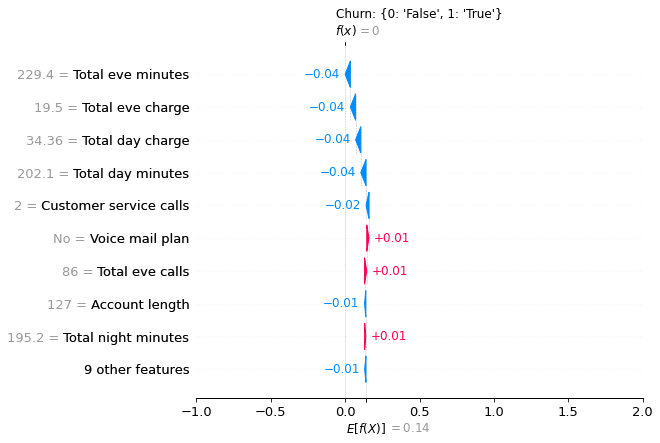

In [16]:
import matplotlib.pyplot as plt
y_categories = fields.one_hot_codes(shap_wrapper.y_header)
y_categories = dict(zip(y_categories.values(), y_categories.keys()))
plt.title("%s: %s" % (shap_wrapper.y_header, y_categories))
plt.xlim([-1, len(y_categories.keys())])

row_number = 0
example = dict(zip(shap_wrapper.x_headers, X_test[row_number])) 
print("Predicting %s from %s" % (shap_wrapper.y_header, example))
shap.plots.waterfall(shap_values[row_number])


### Shap values and probability

We can also ask ourselves about the probability of the previous prediction. The ShapWrapper offers a function that computes the probabilities for each class in the objective field. Let's then build an example to analyze the contribution of each feature to the diabetes diagnosis in the Diabetes dataset:

In [26]:
import pandas as pd
data = pd.read_csv("https://static.bigml.com/csv/diabetes.csv")
data.head()

,pregnancies,plasma glucose,blood pressure,triceps skin thickness,insulin,bmi,diabetes pedigree,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,True
1,1,85,66,29,0,26.6,0.351,31,False
2,8,183,64,0,0,23.3,0.672,32,True
3,1,89,66,23,94,28.1,0.167,21,False
4,0,137,40,35,168,43.1,2.288,33,True


Following the canonical training steps, firstly we split our data and build a model using the training part. In this case, we can build a logistic regression.

In [29]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)

from bigml.api import BigML
USERNAME = "mmartin" # change to use your own credentials
API_KEY = "866c7a8223469924c136bf8d232e5efbd9b60d00" # change to use your own credentials (https://bigml.com/account/apikey)
api = BigML(USERNAME, API_KEY)
source = api.create_source(train)
dataset = api.create_dataset(source)
model = api.create_logistic_regression(dataset)
api.ok(model)

True

In this case, the only categorical field is the one that contains the diabetes diagnosis, and will be encoded as `0` meaning no diabetes and `1` being diabetic.

In [36]:
from bigml.fields import Fields
fields = Fields(model)
fields.list_fields()
print("Diabetes encoding: ", fields.one_hot_codes("diabetes"))

[pregnancies                     : numeric         : 0       ]
[plasma glucose                  : numeric         : 1       ]
[blood pressure                  : numeric         : 2       ]
[triceps skin thickness          : numeric         : 3       ]
[insulin                         : numeric         : 4       ]
[bmi                             : numeric         : 5       ]
[diabetes pedigree               : numeric         : 6       ]
[age                             : numeric         : 7       ]
[diabetes                        : categorical     : 8       ]
Diabetes encoding:  {'False': 0, 'True': 1}


And the logistic regression information can be used locally together with the Shap libary thanks to the `ShapWrapper` class in BigML's Python bindings.

In [35]:
from bigml.shapwrapper import ShapWrapper
shap_wrapper = ShapWrapper(model)

If we are interested in how the probability of the prediction evolves, we can use its method `predict_proba` whose output is an array that contains the probabilities for each class. In this example, we will compute that for some of the elements in our test set.

In [37]:
X_test = fields.to_numpy(test.drop(columns=shap_wrapper.y_header))
probabilities = shap_wrapper.predict_proba(X_test)
print(probabilities)

[[0.76403 0.23597]
 [0.83162 0.16838]
 [0.80258 0.19742]
 [0.89435 0.10565]
 [0.95861 0.04139]
 [0.32466 0.67534]
 [0.64919 0.35081]
 [0.70272 0.29728]
 [0.52807 0.47193]
 [0.42515 0.57485]
 [0.6811  0.3189 ]
 [0.82283 0.17717]
 [0.80168 0.19832]
 [0.17924 0.82076]
 [0.33746 0.66254]
 [0.31227 0.68773]
 [0.63253 0.36747]
 [0.30786 0.69214]
 [0.11012 0.88988]
 [0.51722 0.48278]
 [0.87859 0.12141]
 [0.35249 0.64751]
 [0.66464 0.33536]
 [0.75509 0.24491]
 [0.89693 0.10307]
 [0.50185 0.49815]
 [0.14196 0.85804]
 [0.44286 0.55714]
 [0.63087 0.36913]
 [0.55129 0.44871]
 [0.70371 0.29629]
 [0.24309 0.75691]
 [0.29994 0.70006]
 [0.60817 0.39183]
 [0.74674 0.25326]
 [0.89813 0.10187]
 [0.68659 0.31341]
 [0.79681 0.20319]
 [0.88109 0.11891]
 [0.59741 0.40259]
 [0.8632  0.1368 ]
 [0.20484 0.79516]
 [0.20769 0.79231]
 [0.8082  0.1918 ]
 [0.70804 0.29196]
 [0.76257 0.23743]
 [0.56427 0.43573]
 [0.48467 0.51533]
 [0.33648 0.66352]
 [0.61625 0.38375]
 [0.61804 0.38196]
 [0.97477 0.02523]
 [0.72513 0.

Based on these probabilities, we see that the 5th example seems to correspond to a diabetic patient, so we'll use the Shap library to analyze the contribution of each input property to that probability. 

In [43]:
import numpy as np
import warnings
X_train = fields.to_numpy(train.drop(columns=shap_wrapper.y_header))
explainer = shap.KernelExplainer(shap_wrapper.predict_proba, X_train)
input_array = np.asarray([X_test[4]])
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values = explainer.shap_values(input_array)


100%|█████████████████████████████████████████████| 1/1 [01:30<00:00, 90.49s/it]


As the probability associated to the `True` class is in the second element of the output array, we'll plot that information.

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1], input_array, feature_names=shap_wrapper.x_headers)